<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"
alt="Rubin Observatory logo, a graphical representation of turning stars into data."> <br><br>
**Description:** Generate delivered image quality plots for DP1 data. <br>
**Authors:** Original version for LSSTComCam: Keith Bechtol. Modified version for DP1:  Leanne Guy, <br>
**Last verified to run:** 2025-05-25 <br>
**LSST Science Pipelines version:** v29.0.1<br>
**Container size:** medium <br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

from lsst.daf.butler import Butler
import lsst.geom

# Set a standard figure size to use
from lsst.utils.plotting import publication_plots
from lsst.utils.plotting import get_multiband_plot_colors, get_multiband_plot_symbols, get_multiband_plot_linestyles

In [2]:
instrument = 'LSSTComCam'
collections = ['LSSTComCam/raw/all', 
               'LSSTComCam/DP1/defaults', 
               'LSSTComCam/runs/DRP/DP1/v29_0_0/DM-50260' ]
skymap = 'lsst_cells_v1'
butler = Butler("/repo/dp1",
                instrument=instrument, 
                collections=collections, 
                skymap=skymap)

In [3]:
# Applying the Rubin DP1 paper custom style sheet to all of the graphs to be created in this notebook
publication_plots.set_rubin_plotstyle()
bands_dict = publication_plots.get_band_dicts()
colors = get_multiband_plot_colors()
bands = colors.keys()  # important to get the right order for plot legends
%matplotlib inline

In [4]:
# Force to unpushed updated color scheme.
colors ={"u": "#48A8D4",
         "g": "#31DE1F",
         "r": "#B52626",
         "i": "#2915A4",
         "z": "#AD03EA",
         "y": "#2D0201",
}
bands = colors.keys()  # important to get the right order for plot legends

In [5]:
visit_detector_table = butler.get("visit_detector_table", storageClass="DataFrame")

In [6]:
# Extract and format data for analysis
df = visit_detector_table[['detectorId','visitId', 'band', 'psfSigma','seeing']].copy()
df["psfFwhm"]=df["psfSigma"]*2.355*0.2
df

,detectorId,visitId,band,psfSigma,seeing,psfFwhm
0,0,2024110800245,i,1.832573,0.864554,0.863142
1,1,2024110800245,i,1.746872,0.823865,0.822776
2,2,2024110800245,i,1.789050,0.844020,0.842643
3,3,2024110800245,i,1.822840,0.859669,0.858558
4,4,2024110800245,i,1.713867,0.808050,0.807231
...,...,...,...,...,...,...
16066,4,2024121100611,r,1.650342,0.778259,0.777311
16067,5,2024121100611,r,1.649252,0.777973,0.776798
16068,6,2024121100611,r,1.622512,0.765628,0.764203
16069,7,2024121100611,r,1.640941,0.774048,0.772883


In [7]:
# Best delivered IQ
min_row = df.loc[df['psfFwhm'].idxmin()]
min_row

detectorId                7
visitId       2024112400119
band                      i
psfSigma           0.288675
seeing             0.136147
psfFwhm            0.135966
Name: 3643, dtype: object

In [8]:
# This is very low -- 0.135 arcsec seeing is not physical.
# How should these be treated in the analysis? 
rows = df[df['visitId'] == 2024112400119]
rows

,detectorId,visitId,band,psfSigma,seeing,psfFwhm
3636,0,2024112400119,i,2.357925,1.112520,1.110583
3637,1,2024112400119,i,2.344967,1.106029,1.104479
3638,2,2024112400119,i,2.326107,1.097483,1.095596
3639,3,2024112400119,i,2.380226,1.122648,1.121087
3640,4,2024112400119,i,2.380704,1.122506,1.121312
3641,5,2024112400119,i,2.323589,1.095907,1.094410
3642,6,2024112400119,i,2.521431,1.189638,1.187594
3643,7,2024112400119,i,0.288675,0.136147,0.135966
3644,8,2024112400119,i,2.675308,1.262324,1.260070


In [9]:
# This is clearly non-physical 
# Count number of visits with IQ <= 0.65 (or threshold)
t_low = 0.5
t_high = 0.6
df_iq_analysis = df[(df['psfFwhm'] >= t_low) & (df['psfFwhm'] < t_high)]
visit_detector_pairs = df_iq_analysis[['visitId', 'detectorId', 'psfFwhm']].drop_duplicates().values.tolist()
print(f"Visit/Dector pairs with IQ in {t_low}, {t_high}\nID (visitId, detectorId, psfFwhm): {visit_detector_pairs}")

Visit/Dector pairs with IQ in 0.5, 0.6
ID (visitId, detectorId, psfFwhm): [[2024112400274.0, 4.0, 0.599747359752655], [2024112400274.0, 5.0, 0.5870388150215149], [2024112400274.0, 6.0, 0.5765321850776672], [2024112400274.0, 7.0, 0.5760278105735779]]


In [10]:
# This is clearly non-physical 
# Current analysis -- Put a lower cut on IQ at 0.6  to exclude non-physical values 
# -- based on SITCOMTN report of 0.65 bing best IQ 

# remove artificial cut for analysis
#df = df[df['psfFwhm'] >= 0.6]

In [11]:
min_row = df.loc[df['psfFwhm'].idxmin()]
print(f"Best delivered image quality {min_row}")

Best delivered image quality detectorId                7
visitId       2024112400119
band                      i
psfSigma           0.288675
seeing             0.136147
psfFwhm            0.135966
Name: 3643, dtype: object


In [12]:
# Compute all band summary statistics
quantiles = [25, 50, 75]

iq_summary_all = df['psfFwhm'].quantile([q/100 for q in quantiles]).apply(
    lambda x: round(x, 2)).to_frame().T
iq_summary_all['mean'] = round(df['psfFwhm'].mean(), 2)
iq_summary_all.index = ['all']
iq_summary_all.index.name = 'band'

# Compute summary statistics by band 
iq_summary_band = df.groupby('band')['psfFwhm'].quantile(
    [q / 100 for q in quantiles]).apply(
    lambda x: round(x, 2)).unstack()
iq_summary_band['mean'] = df.groupby('band')['psfFwhm'].mean().round(2)
iq_summary_band.index.name = 'band'

# Concatenate and sort and set type 
iq_summary = pd.concat([iq_summary_band, iq_summary_all])
iq_summary = iq_summary.astype(float)
band_order =  list(bands) +  ['all'] 
iq_summary.index = pd.CategoricalIndex(
    iq_summary.index, categories=band_order, 
    ordered=True, name='band')
iq_summary = iq_summary.sort_index()
iq_summary

,0.25,0.5,0.75,mean
band,,,,
u,1.34,1.48,1.67,1.54
g,1.07,1.17,1.29,1.20
r,0.99,1.12,1.22,1.11
i,0.92,1.03,1.13,1.03
z,0.98,1.11,1.21,1.10
y,0.94,1.01,1.10,1.03
all,1.00,1.12,1.25,1.14


In [13]:
# Convert to latex format
# Insert blank colum for nice spacing in table 
data_latex = iq_summary.drop('mean', axis=1)
data_latex.insert(0, ' ', ' ')
data_latex = data_latex.to_latex(index=True, 
                                       bold_rows=False, float_format='%.2f'
                            )
data_latex = data_latex.split("midrule\n", 1)[-1]  # Keeps the part after 'midrule'
data_latex = data_latex.split("\\bottomrule", 1)[0]  # Keeps the part before 'bottomrule'
data_latex

'u &   & 1.34 & 1.48 & 1.67 \\\\\ng &   & 1.07 & 1.17 & 1.29 \\\\\nr &   & 0.99 & 1.12 & 1.22 \\\\\ni &   & 0.92 & 1.03 & 1.13 \\\\\nz &   & 0.98 & 1.11 & 1.21 \\\\\ny &   & 0.94 & 1.01 & 1.10 \\\\\nall &   & 1.00 & 1.12 & 1.25 \\\\\n'

In [14]:
# Write to latex table
with open("../tables/image_quality_summary.tex", "w") as f:
    f.write(r"""%%%%% This table is auto generated from data, DO NOT EDIT
\setlength{\tabcolsep}{14pt} 
\begin{deluxetable*}{ccccc}
\tablecaption{Image quality expressed in terms of PSF FWHM in arcseconds per band and for all bands.
\label{tab:image_quality} }
\tablehead{
  \colhead{\textbf{Band}} && \multicolumn{3}{c}{\textbf{Quantile (\%)}} \\
  \cline{3-5}
   & & 25& 50& 75 
}
\startdata
""")
    f.write(data_latex)
    f.write(r"""\enddata
\end{deluxetable*}
""")
f.close()

## Plots of the Image quality 

In [15]:
# Extract data from visit table for plotting
data = {}
for band in bands:
    data[band] = np.array(df[df['band'].str.contains(band)]['psfFwhm']) 

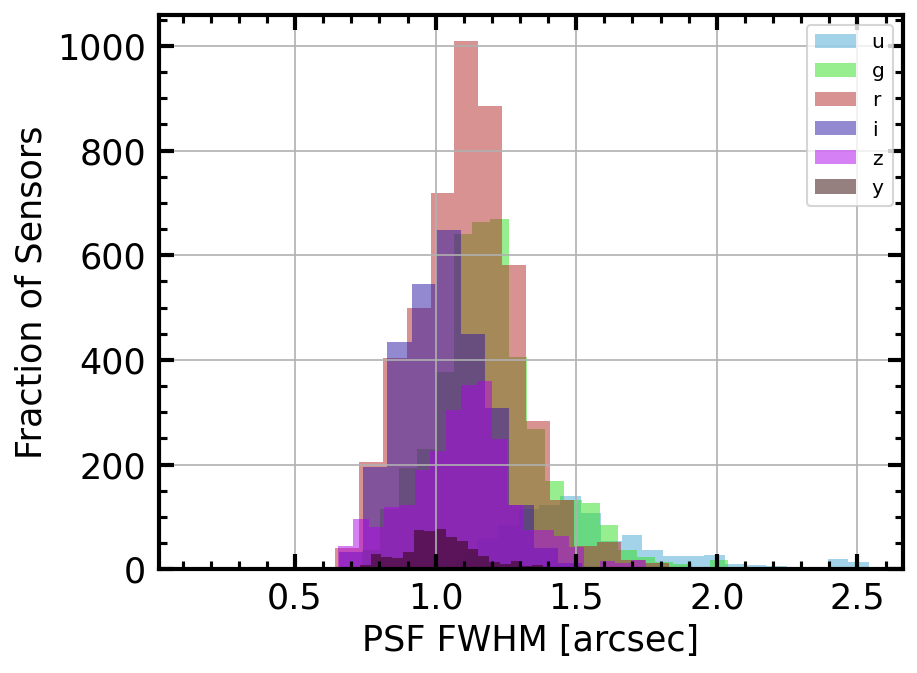

In [16]:
# IQ histogram - not for inclusion in the paper but interesting
plt.figure()

for label, d in data.items():
    plt.hist(d, bins=20, alpha=0.5,
             linestyle='-',
             color = colors[label],
             label=label)

# Customize plot
plt.xlabel('PSF FWHM [arcsec]')
plt.ylabel('Fraction of Sensors')
plt.grid(True)
plt.legend()
# plt.xlim(0, 0.9)  
# plt.ylim(0, 500) 

plt.savefig("../figures/image_quality_histo.pdf", 
            bbox_inches='tight',  # Trim whitespace around the figure
            transparent=True,     # Transparent background
            format='png')         # Explicit format specification
plt.show()

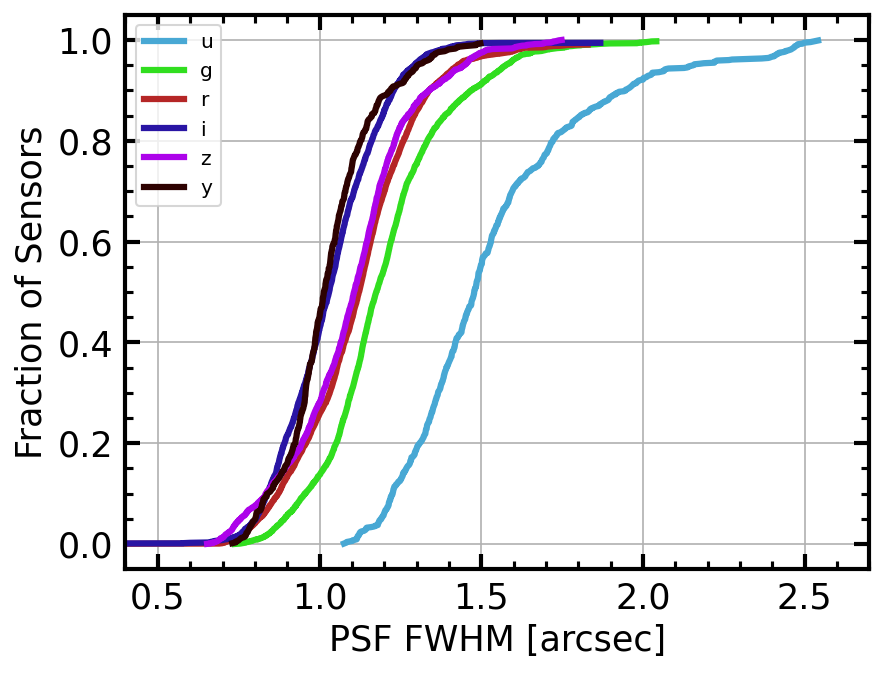

In [17]:
# IQ ECDF
plt.figure()

for label, d in data.items():
    ecdf = ECDF(d)
    plt.plot(ecdf.x, ecdf.y, 
             linestyle='-',
             color = colors[label],
             label=label)

# Customize plot
plt.xlabel('PSF FWHM [arcsec]')
plt.ylabel('Fraction of Sensors')
plt.grid(True)
plt.xlim(0.4, 2.7)
plt.legend()
plt.savefig("../figures/image_quality_ecdf.pdf", 
            bbox_inches='tight',  # Trim whitespace around the figure
            transparent=True,     # Transparent background
            format='png')         # Explicit format specification
plt.show()

In [18]:
# Investigate the variation by field -- expect to be minimal
# TODO

In [19]:
plt.close()